In [1]:
import os
import time
import copy
import torch
import torchvision

import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torchvision.models as models
import torch.nn.functional as F
import torchvision.transforms as transforms

from PIL import Image
from torchvision.datasets import ImageFolder
from torchvision.utils import make_grid
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split
from torch.autograd import Variable

%matplotlib inline

In [2]:
# Fixed rand. seed for reproducibility of results
torch.manual_seed(42)

In [3]:
# set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [4]:
# Source: Post by "kuzand" @https://discuss.pytorch.org/t/computing-the-mean-and-std-of-dataset/34949/2
def get_mean_std(loader):
    mean = 0.
    std = 0.
    for images, _ in loader:
        batch_samples = images.size(0) # batch size (the last batch can have smaller size!)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
    mean /= len(loader.dataset)
    std /= len(loader.dataset)
    return mean, std

In [5]:
imsize = 125
data_dir = 'data'

In [6]:
# Compute mean and std of training data
img_loader = ImageFolder(os.path.join(data_dir, 'train'), transforms.Compose([
    transforms.Resize((imsize, imsize)),
    transforms.ToTensor()
]))
data_loader = DataLoader(img_loader, batch_size=4, shuffle=False, num_workers=4)
train_mean, train_std = get_mean_std(data_loader)

In [7]:
train_mean, train_std

(tensor([0.5751, 0.5640, 0.4498]), tensor([0.2618, 0.2595, 0.2629]))

In [8]:
# Source: https://pytorch.org/tutorials/beginner/transfer_learning_tutorial.html

In [9]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(int(0.8 * imsize)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean, std=train_std)
    ]),
    'val': transforms.Compose([
        transforms.Resize(imsize),
        transforms.CenterCrop(int(0.8 * imsize)),
        transforms.ToTensor(),
        transforms.Normalize(mean=train_mean, std=train_std)
    ]),
}

image_datasets = {x: ImageFolder(os.path.join(data_dir, x), data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: DataLoader(image_datasets[x], batch_size=4,
                                              shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [10]:
# Show a couple images
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array(train_mean)
    std = np.array(train_std)
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(1)  # pause a bit so that plots are updated

In [11]:
# # Get a batch of training data
# inputs, classes = next(iter(dataloaders['train']))

# # Make a grid from batch
# out = torchvision.utils.make_grid(inputs)

# imshow(out, title=[class_names[x] for x in classes])

In [12]:
# Train the model
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(
                phase, epoch_loss, epoch_acc))

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(
        time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [13]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title('predicted: {}'.format(class_names[preds[j]]))
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [14]:
model_ft = models.resnet18(pretrained=True)
# for param in model_ft.parameters():
#     param.requires_grad = False

num_ftrs = model_ft.fc.in_features

model_ft.fc = nn.Linear(num_ftrs, len(class_names))

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = torch.optim.SGD(model_ft.parameters(), lr=0.001, momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [15]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler, num_epochs=25)

Epoch 0/24
----------
train Loss: 0.7128 Acc: 0.5930
val Loss: 0.7925 Acc: 0.6667

Epoch 1/24
----------
train Loss: 0.6265 Acc: 0.6860
val Loss: 0.5270 Acc: 0.8000

Epoch 2/24
----------
train Loss: 0.5996 Acc: 0.6744
val Loss: 0.4448 Acc: 0.8333

Epoch 3/24
----------
train Loss: 0.8320 Acc: 0.6279
val Loss: 0.3586 Acc: 0.7667

Epoch 4/24
----------
train Loss: 0.8026 Acc: 0.7209
val Loss: 0.9949 Acc: 0.6333

Epoch 5/24
----------
train Loss: 0.4643 Acc: 0.7791
val Loss: 0.9175 Acc: 0.7667

Epoch 6/24
----------
train Loss: 0.8906 Acc: 0.7442
val Loss: 0.9823 Acc: 0.8000

Epoch 7/24
----------
train Loss: 1.0837 Acc: 0.7674
val Loss: 0.5058 Acc: 0.8667

Epoch 8/24
----------
train Loss: 0.4684 Acc: 0.8372
val Loss: 0.3172 Acc: 0.9333

Epoch 9/24
----------
train Loss: 0.2547 Acc: 0.8953
val Loss: 0.2538 Acc: 0.9000

Epoch 10/24
----------
train Loss: 0.2433 Acc: 0.9070
val Loss: 0.3447 Acc: 0.8667

Epoch 11/24
----------
train Loss: 0.4613 Acc: 0.8953
val Loss: 0.4765 Acc: 0.8333

Ep

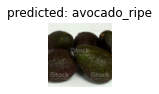

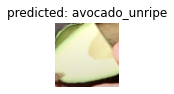

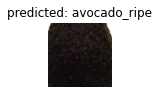

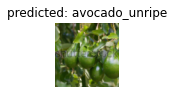

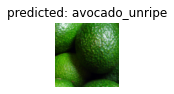

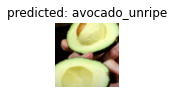

In [17]:
visualize_model(model_ft)

In [18]:
loader = transforms.Compose([
    transforms.Resize(imsize),
    transforms.ToTensor(), 
    transforms.Normalize(mean=train_mean, std=train_std)
])

def predict(model, img_path):
    # image = image_loader(img_path)
    img = Image.open(img_path)
    plt.imshow(img)
    img = loader(img).float()
    img = img.unsqueeze(0)  #this is for VGG, may not be needed for ResNet
    # plt.imshow(transforms.ToPILImage()(image.squeeze(0)))
    p, idx = F.softmax(model.forward(img)).max(1)
    return p.item(), class_names[idx]

(0.9507029056549072, 'avocado_ripe')

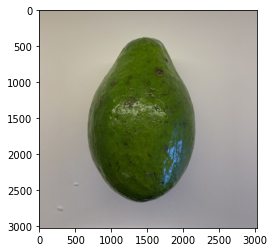

In [19]:
predict(model_ft, 'data/avocado_2.jpg')

In [20]:
torch.save(model_ft.state_dict(), 'model')

In [23]:
dict(enumerate(class_names))

{0: 'avocado_ripe', 1: 'avocado_unripe'}